In [10]:
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [2]:
(train_ds, test_ds), ds_info = tfds.load(
    'lfw',
    as_supervised=True,
    with_info=True,
    split=['train[:80%]', 'train[80%:]'],
)

In [3]:
n = ds_info.splits['train'].num_examples

In [4]:
MARGIN = 20.0

def contrastive_loss(embeddings, labels, margin=MARGIN):
    batch_size = embeddings.shape[0]
    embeddings_1 = embeddings[:batch_size//2, :]
    embeddings_2 = embeddings[batch_size//2:, :]
    labels_1 = labels[:batch_size//2]
    labels_2 = labels[batch_size//2:]

    d_squared = tf.reduce_sum(tf.square(embeddings_1 - embeddings_2), axis=1)
    d =  tf.sqrt(d_squared)
    z = tf.cast(labels_1 == labels_2, tf.float32)
    
    return tf.reduce_mean(z * d**2 + (1-z) * tf.maximum(0, margin - d)**2)

In [5]:
def preprocess(label, image):
    return label, tf.cast(image, tf.float32) / 255.

In [6]:
BATCH_SIZE = 64
NUM_EPOCHS = 16

train_ds = train_ds.map(preprocess)
train_ds = train_ds.shuffle(np.ceil(n/2))
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)

test_ds = test_ds.shuffle(np.ceil(n/2))
test_ds = test_ds.map(preprocess)
test_ds = test_ds.batch(BATCH_SIZE, drop_remainder=True)

In [7]:
EMB_SIZE = 64

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(EMB_SIZE, activation=None),
])

In [8]:
LEARNING_RATE = 0.001
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

In [9]:
%%time

for iteration, (labels, images) in enumerate(train_ds):
    
    # Forward
    with tf.GradientTape() as tape:
        embs = model(images)
        loss_value = contrastive_loss(embs, labels)
        
    # Backward
    grads = tape.gradient(loss_value, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))

    if iteration % 200 == 0:
        print('[{}] Loss: {}'.format(iteration, loss_value.numpy()))

[0] Loss: 382.2450256347656
[200] Loss: 0.0009599248296581209
[400] Loss: 0.0
[600] Loss: 0.012833642773330212
[800] Loss: 0.17541618645191193
[1000] Loss: 1.8844103813171387
[1200] Loss: 30.321392059326172
[1400] Loss: 0.0
[1600] Loss: 0.0
[1800] Loss: 8.123931884765625
[2000] Loss: 0.6494159698486328
[2200] Loss: 0.1043379008769989
[2400] Loss: 0.26058483123779297
[2600] Loss: 2.3478941917419434
CPU times: user 8h 32min 30s, sys: 1h 44min 40s, total: 10h 17min 11s
Wall time: 1d 18h 54min 27s


In [11]:
def load_and_prepare_image(fpath):
    import imageio
    from skimage.transform import resize
    img = imageio.imread(fpath, pilmode="RGB")
    img = img.astype(np.float32)/255
    img = resize(img, (250, 250, 3), mode='reflect', anti_aliasing=True)
    img = np.reshape(img, (250, 250, 3))
    return img

In [83]:
img_a1 = load_and_prepare_image('https://upload.wikimedia.org/wikipedia/commons/e/ef/WikipediaBaudrillard20040612-cropped.png')
img_a2 = load_and_prepare_image('https://i.ytimg.com/vi/1BmbW9ZbHw8/hqdefault.jpg')

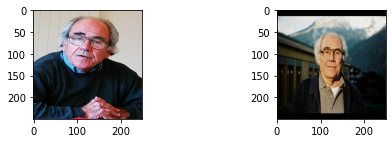

In [100]:
fig, ax = plt.subplots(1, 2, figsize=(8, 2))
ax[0].imshow(img_a1)
ax[1].imshow(img_a2)

In [106]:
img_b1 = load_and_prepare_image('https://static.diary.ru/userdir/2/8/3/6/283669/59131043.jpg')
img_b2 = load_and_prepare_image('https://www.topnews.ru/upload/photo/57ae893d/7da22.jpg')

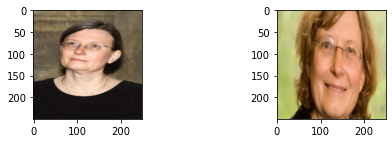

In [107]:
fig, ax = plt.subplots(1, 2, figsize=(8, 2))
ax[0].imshow(img_b1)
ax[1].imshow(img_b2)

In [85]:
img_с1 = load_and_prepare_image('https://radiokp.ru/sites/default/files/styles/kp_fullnode_730_486/public/2020-08/dugin-vislov-ivan.jpg?itok=CDjyn8Vr')
img_с2 = load_and_prepare_image('https://cdn-st1.rtr-vesti.ru/vh/pictures/xw/526/188.jpg')

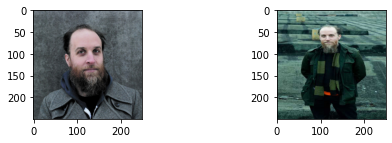

In [108]:
fig, ax = plt.subplots(1, 2, figsize=(8, 2))
ax[0].imshow(img_c1)
ax[1].imshow(img_c2)

In [109]:
embs = model(np.stack((img_a1, img_a2, 
                       img_b1, img_b2, 
                       img_c1, img_c2), axis=0))

In [110]:
def diff(e1, e2):
    return np.sum((e1 - e2)**2) ** 0.5

In [111]:
emb_a1 = embs[0,:]
emb_a2 = embs[1,:]

emb_b1 = embs[2,:]
emb_b2 = embs[3,:]

emb_c1 = embs[4,:]
emb_c2 = embs[5,:]

In [114]:
print('A1 <-> A2: ', diff(emb_a2, emb_a1))
print('A1 <-> B1: ', diff(emb_a2, emb_b1))
print('A1 <-> C1: ', diff(emb_a2, emb_c1))

print("-------------------------------")

print('B1 <-> B2: ', diff(emb_b1, emb_b2))
print('B1 <-> C1: ', diff(emb_b1, emb_c1))

print("-------------------------------")

print('C1 <-> C2: ', diff(emb_c1, emb_c2))

A1 <-> A2:  27.54365099185178
A1 <-> B1:  34.87222071138788
A1 <-> C1:  34.428025508728894
-------------------------------
B1 <-> B2:  31.054400548988724
B1 <-> C1:  26.121584144211564
-------------------------------
C1 <-> C2:  17.502780366462943


##### Рузультат довольно посредственный, возмодно модель плохо обучилась